In [1]:
import random
from itertools import accumulate
import statistics
import math
import matplotlib.pyplot as plt

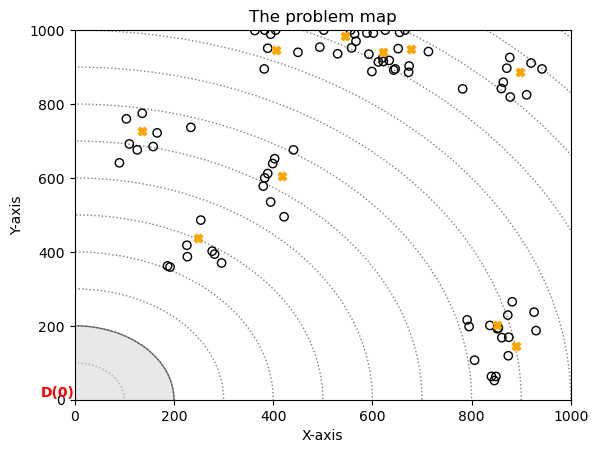

In [4]:
%run Utils.ipynb
%run Operators.ipynb
%run Plotting.ipynb

In [5]:
def roulettewheel(operators, probabilities):

    p = random.random()
    
    probs = list(accumulate(probabilities))
    
    for index, prob in enumerate(probs):
        if prob>= p:
            return operators[index], index

In [6]:
def accept_ALNS(best_cost,curr_cost,new_cost,iter,max_iter):
    if new_cost<curr_cost:
        return True, (0.2*((max_iter-iter)/max_iter)*best_cost)+best_cost
    else:
        D = 0.2*((max_iter-iter)/max_iter)*best_cost
        
        #Alternatively
        #D = 0.01*best_cost
        
        threshold = best_cost+D
        
        return new_cost<=threshold, threshold 

In [7]:
def normalize_weights(weights):

    total_weight = abs(sum(weights))
    normalized_weights = [0]*(len(weights))
    
    for i in range(len(weights)):
        curr = weights[i]
        normalized_weights[i] = curr/total_weight
    
    
    return normalized_weights

In [ ]:
def ALNS_roulettewheel(operators,weights):
    total_wieght = sum(weights)
    rand_val = random.uniform(0, total_wieght)
    partial_sum = 0.0
    
    for i in range(len(weights)):
        partial_sum += weights[i]
        if partial_sum >= rand_val:
            return operators[i], i  

In [ ]:
def weight_adjustment(weights,scores,used,r):
    for i in range(len(weights)):
        curr = weights[i]
        if used[i] == 0 and scores[i] == 0:
            add_on = 0
        else:
            add_on = r*scores[i]/used[i]
    
        weights[i] = curr*(1-r) + add_on
    
    new_weigths = [0 for x in weights]
    for w in range(len(weights)):
        weight = weights[w]/sum(weights)
        new_weigths[w] = weight
    #legge til nedre grense min(0.1,weights)

    return new_weigths

In [ ]:
def simple_sim_annealing(initial, problem, operators, probabilities):
    T_f = 0.1
    Incumbent = initial[0]
    BestSolution = Incumbent
    
    IncumbentCost = objective_function(initial, problem)
    BestCost = IncumbentCost
    
    n_feasible = 0
    
    delta_E = 0
    
    delta_w = []
    
    good_value = False  # This can be used to make the model go on once it is stuck
    
    cost_values = []  # List to store the cost values
    
    for w in range(100):
        operator, _ = roulettewheel(operators, probabilities)
        NewSolution = operator(Incumbent, problem, 5)
        NewSolution, ProseccedSolution, feasible_charge = postprocessing(NewSolution, problem)
        feasible_vessels, str = feasibility_check(ProseccedSolution, problem)
        
        if feasible_vessels and feasible_charge:
            n_feasible += 1
        
            NewCost = objective_function(ProseccedSolution, problem)
            
            delta_E = NewCost - IncumbentCost
            
            if delta_E < 0:
                Incumbent = NewSolution
                IncumbentCost = NewCost
                if IncumbentCost < BestCost:
                    BestSolution = Incumbent
                    BestCost = IncumbentCost
                
            else:
                if random.random() < 0.8:
                    Incumbent = NewSolution
                    IncumbentCost = NewCost
                
                delta_w.append(delta_E)
        
        cost_values.append(IncumbentCost)  # Append the cost value to the list
    
    delta_w = [x for x in delta_w if x > 0]
    
    print('Finished with first loop')
    
    DeltaAvg = statistics.mean(delta_w)
    
    T_0 = -DeltaAvg / math.log(0.8)  # can be changed
    
    alpha = (T_f / T_0) ** (1 / 9900)
    
    T = T_0
    
    for _ in range(9900):
        operator, _ = roulettewheel(operators, probabilities)
        NewSolution = operator(Incumbent, problem, 1)
        NewSolution, ProseccedSolution, feasible_charge = postprocessing(NewSolution, problem)
        feasible_vessels, str = feasibility_check(ProseccedSolution, problem)
                
        if feasible_charge and feasible_vessels:
            n_feasible += 1
            
            NewCost = objective_function(ProseccedSolution, problem)
            
            delta_E = NewCost - IncumbentCost
            
            p = math.e ** (-delta_E / T)
            
            if delta_E < 0:
                Incumbent = NewSolution
                IncumbentCost = NewCost

                if IncumbentCost < BestCost:
                    BestSolution = Incumbent
                    BestCost = IncumbentCost
                    # improvement_distribution[index] +=1
                    # last_improv = 100+j
                
            elif random.random() < p:
                Incumbent = NewSolution
                IncumbentCost = NewCost
            
            T *= alpha
            # push!(T_list, T)
            
        cost_values.append(IncumbentCost)  # Append the cost value to the list
    
    return BestSolution, BestCost, n_feasible, cost_values  # Return the list of cost values    

In [ ]:
def ALNS(inital,problem,operators,n_iter,weights = None):
    
    print('Starting ALNS')
    #print(f'Initial solution: {inital}')
    #print(f'Initial cost: {objective_function(inital,problem)}')
    
    escape_method = 2
    
    n_calls = len(problem["Nodes"])
    max_iter = n_iter
    
    
    
    
    curr_solution = inital[0]
    curr_cost = objective_function(inital, problem)
    
    best_solution = curr_solution
    best_cost = curr_cost
    if not weights:
        weights = [1/len(operators) for _ in range(len(operators))]
    
    
    scores = [0 for _ in range(len(operators))]
    used = [0 for _ in range(len(operators))]
    
    last_improvement = 0
    final_improvement = 0
    
    r = 0.1
    
    unique = 1
    
    
    
    found_solutions = {} #solution as key and cost as value
    seen = tuple(curr_solution)
    found_solutions[seen] = curr_cost
    
    all_scores = []
    all_used = []
    all_weights = []
    costs = []
    best_costs = []
    accept_list = []
    deltas = []
    
    segment = 1
    segment_length = 100
    q_max = max(5,n_calls//20)
    escape_q = max(5, n_calls//5)
    escape_m = 20
    escape = 0
    
    for i in range(max_iter):

        if i%1000 == 0 and i>0:
            print(f'Iteration {i//1000}k')
            
        
        
        costs.append(curr_cost)
        best_costs.append(best_cost)
        
        q = rd.randint(1,q_max)
        
        if i-final_improvement>15000:
            print(f'Its been too long, breaking at {i}')
            break
        
        
        if last_improvement>1000: #KAN ENDRES
            if escape_method == 1:
                print(f'Escape at {i}')
                curr_solution = escape1_0(curr_solution,problem,escape_q)
                curr_solution, processed_solution, feasible_pp = postprocessing(curr_solution, problem)
                curr_cost = objective_function(processed_solution,problem)
                last_improvement = 0
                continue
            elif escape_method == 2:
                print(f'Escape at {i}')
                escape = escape_m
                last_improvement = 0
        
        if escape>0:
            new_solution = escape2_0(curr_solution,problem,q)
            new_solution, processed_solution, feasible_pp = postprocessing(new_solution, problem)
            new_cost = objective_function(processed_solution,problem)
            idx = 0
            used[idx] += 1 ##MAKE SURE THIS IDX IS THE SAME AS THE INDEX FOR THE ESCAPE OPERATOR
        
            
            escape -= 1
            
            if new_cost<best_cost:
                escape = 0
                curr_solution = new_solution
                curr_cost = new_cost
                best_solution = curr_solution
                best_cost = curr_cost
                
        else:    
            operator, idx = roulettewheel(operators, weights)
            new_solution = operator(curr_solution,problem,q)
            new_solution, processed_solution, feasible_pp = postprocessing(new_solution, problem)
            #feasible_vessels, str = feasibility_check(processed_solution, problem)
            used[idx] += 1
            
       
        
        
        if not feasible_pp:
            print(f"Not feasible post processing using operator {str(operators[idx])}")
        if feasible_pp:
            
            
            score = 0
            
            seen = tuple(new_solution)
            
            if seen in found_solutions.keys():
                new_cost = found_solutions[seen]
            else:
                new_cost = objective_function(processed_solution, problem)
                score = 1
                unique += 1
                found_solutions[seen] = new_cost
                
        
            
            delta = new_cost - curr_cost
            deltas.append((i,delta,idx))
            
            if new_cost < best_cost:
                best_solution = new_solution
                best_cost = new_cost
                last_improvement = 0
                final_improvement = i
                #print(f'New best cost at {i} with cost {best_cost}')
                score = 4
            elif new_cost < curr_cost:
                score = 2
            if escape == 0:
                scores[idx] += score
            
            accept, D = accept_ALNS(best_cost,curr_cost,new_cost,i,max_iter)
            
            accept_list.append(D)
            if escape > 0:
                escape-=1
                curr_solution = new_solution
                curr_cost = new_cost
                
            if accept:
                curr_solution = new_solution
                curr_cost = new_cost
            
            if i%segment_length == 0:
                all_weights.append(weights)
                all_scores.append(scores)
                new_weights = weight_adjustment(weights,scores,used,r)
                segment += 1
                scores = [0 for _ in range(len(operators))]
                used = [0 for _ in range(len(operators))]
                weights = new_weights
                
            last_improvement+=1
    
    processed_best = postprocessing(best_solution,problem)[1]
    
    print(f'Best cost: {best_cost}')
    
    return best_solution,processed_best,best_cost,best_costs,costs,all_weights,all_scores,all_used,final_improvement,unique,accept_list, deltas
               